In [ ]:
!curl -C - -o stratified_20160110_20191231_sample_1GB.csv http://geobrain.csiss.gmu.edu/wildfire_site/data/stratified_20160110_20191231_sample_1GB.csv


# Wildfire Training Data Retrieval

This notebook will test foundational models that would predict wildfires (FRP, fire radiative power) given the past observations of wind, humidity, rain, etc. This work is based on research by Ziheng Sun, Yunyao Li, Daniel Tong, et al.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("stratified_20160110_20191231_sample_1GB.csv")
df

,FRP_1_days_ago,Nearest_1,Nearest_5,Nearest_7,Nearest_3,FRP_2_days_ago,V,U,LAT,LON,Nearest_17,Land_Use,RH,T,RAIN,FRP
0,0.000000,0.000032,0.000032,0.000032,0.000032,0.0,-1.43000,2.185000,35.599998,179.300018,0.000032,0.0,296.200012,78.275002,40.174999,0.000032
1,0.000000,0.000041,0.000000,0.000021,0.000021,0.0,5.55000,-6.307500,58.199997,-62.099998,0.000021,0.0,278.950012,85.099998,27.425001,0.000021
2,0.000000,0.000008,0.000008,0.000008,0.000008,0.0,2.67250,-2.652500,77.800003,43.300003,0.000008,0.0,273.925018,84.500000,24.799999,0.000008
3,0.000000,0.000023,0.000023,0.000023,0.000023,0.0,0.04250,0.760000,54.699997,37.199997,0.000023,9.0,293.400024,59.875000,31.975000,0.000023
4,0.000000,0.000008,0.000008,0.000008,0.000008,0.0,2.64750,-2.567500,77.800003,43.500000,0.000008,0.0,273.925018,84.199997,24.775000,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9126181,0.000010,0.000000,0.000000,0.000000,0.000000,0.0,1.73397,-0.471789,46.600006,-101.400002,0.000000,10.0,292.764465,76.099998,25.200001,0.000000
9126182,0.000017,0.000000,0.000000,0.000000,0.000000,0.0,6.12397,-4.454289,-29.599998,9.199997,0.000000,0.0,289.389465,84.900002,18.225000,0.000000
9126183,0.000004,0.000000,0.000000,0.000000,0.000000,0.0,6.46397,2.528211,77.600006,50.900009,0.000000,0.0,275.664459,99.650002,24.750000,0.000000
9126184,0.000015,0.000000,0.000000,0.000000,0.000000,0.0,0.49647,9.393211,-38.799999,-140.000000,0.000000,0.0,285.714478,69.099998,12.900000,0.000000


In [3]:
# print all the columns
df.columns

Index(['FRP_1_days_ago', 'Nearest_1', 'Nearest_5', 'Nearest_7', 'Nearest_3',
       'FRP_2_days_ago', 'V', 'U', 'LAT', 'LON', 'Nearest_17', 'Land_Use',
       'RH', 'T', 'RAIN', 'FRP'],
      dtype='object')

In [ ]:
# choose random 5 points
# Randomly select five unique (LAT, LON) pairs
random_points = df[['LAT', 'LON']].drop_duplicates().sample(n=5, random_state=42)
random_points

In [ ]:
# Filter the DataFrame for the selected LAT, LON pairs
df_selected = df.merge(random_points, on=['LAT', 'LON'])
df_selected

## Separate the training, testing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = df.drop(columns=['FRP'])  # Drop the FRP column to use all other columns as features
y = df['FRP']  # Target variable

# Handle any missing values if necessary (e.g., by filling them or dropping rows)
X.fillna(0, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Test run on Random Forest and check the variable important

In [ ]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Relative to FRP')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


### Scattered variable comparion plots

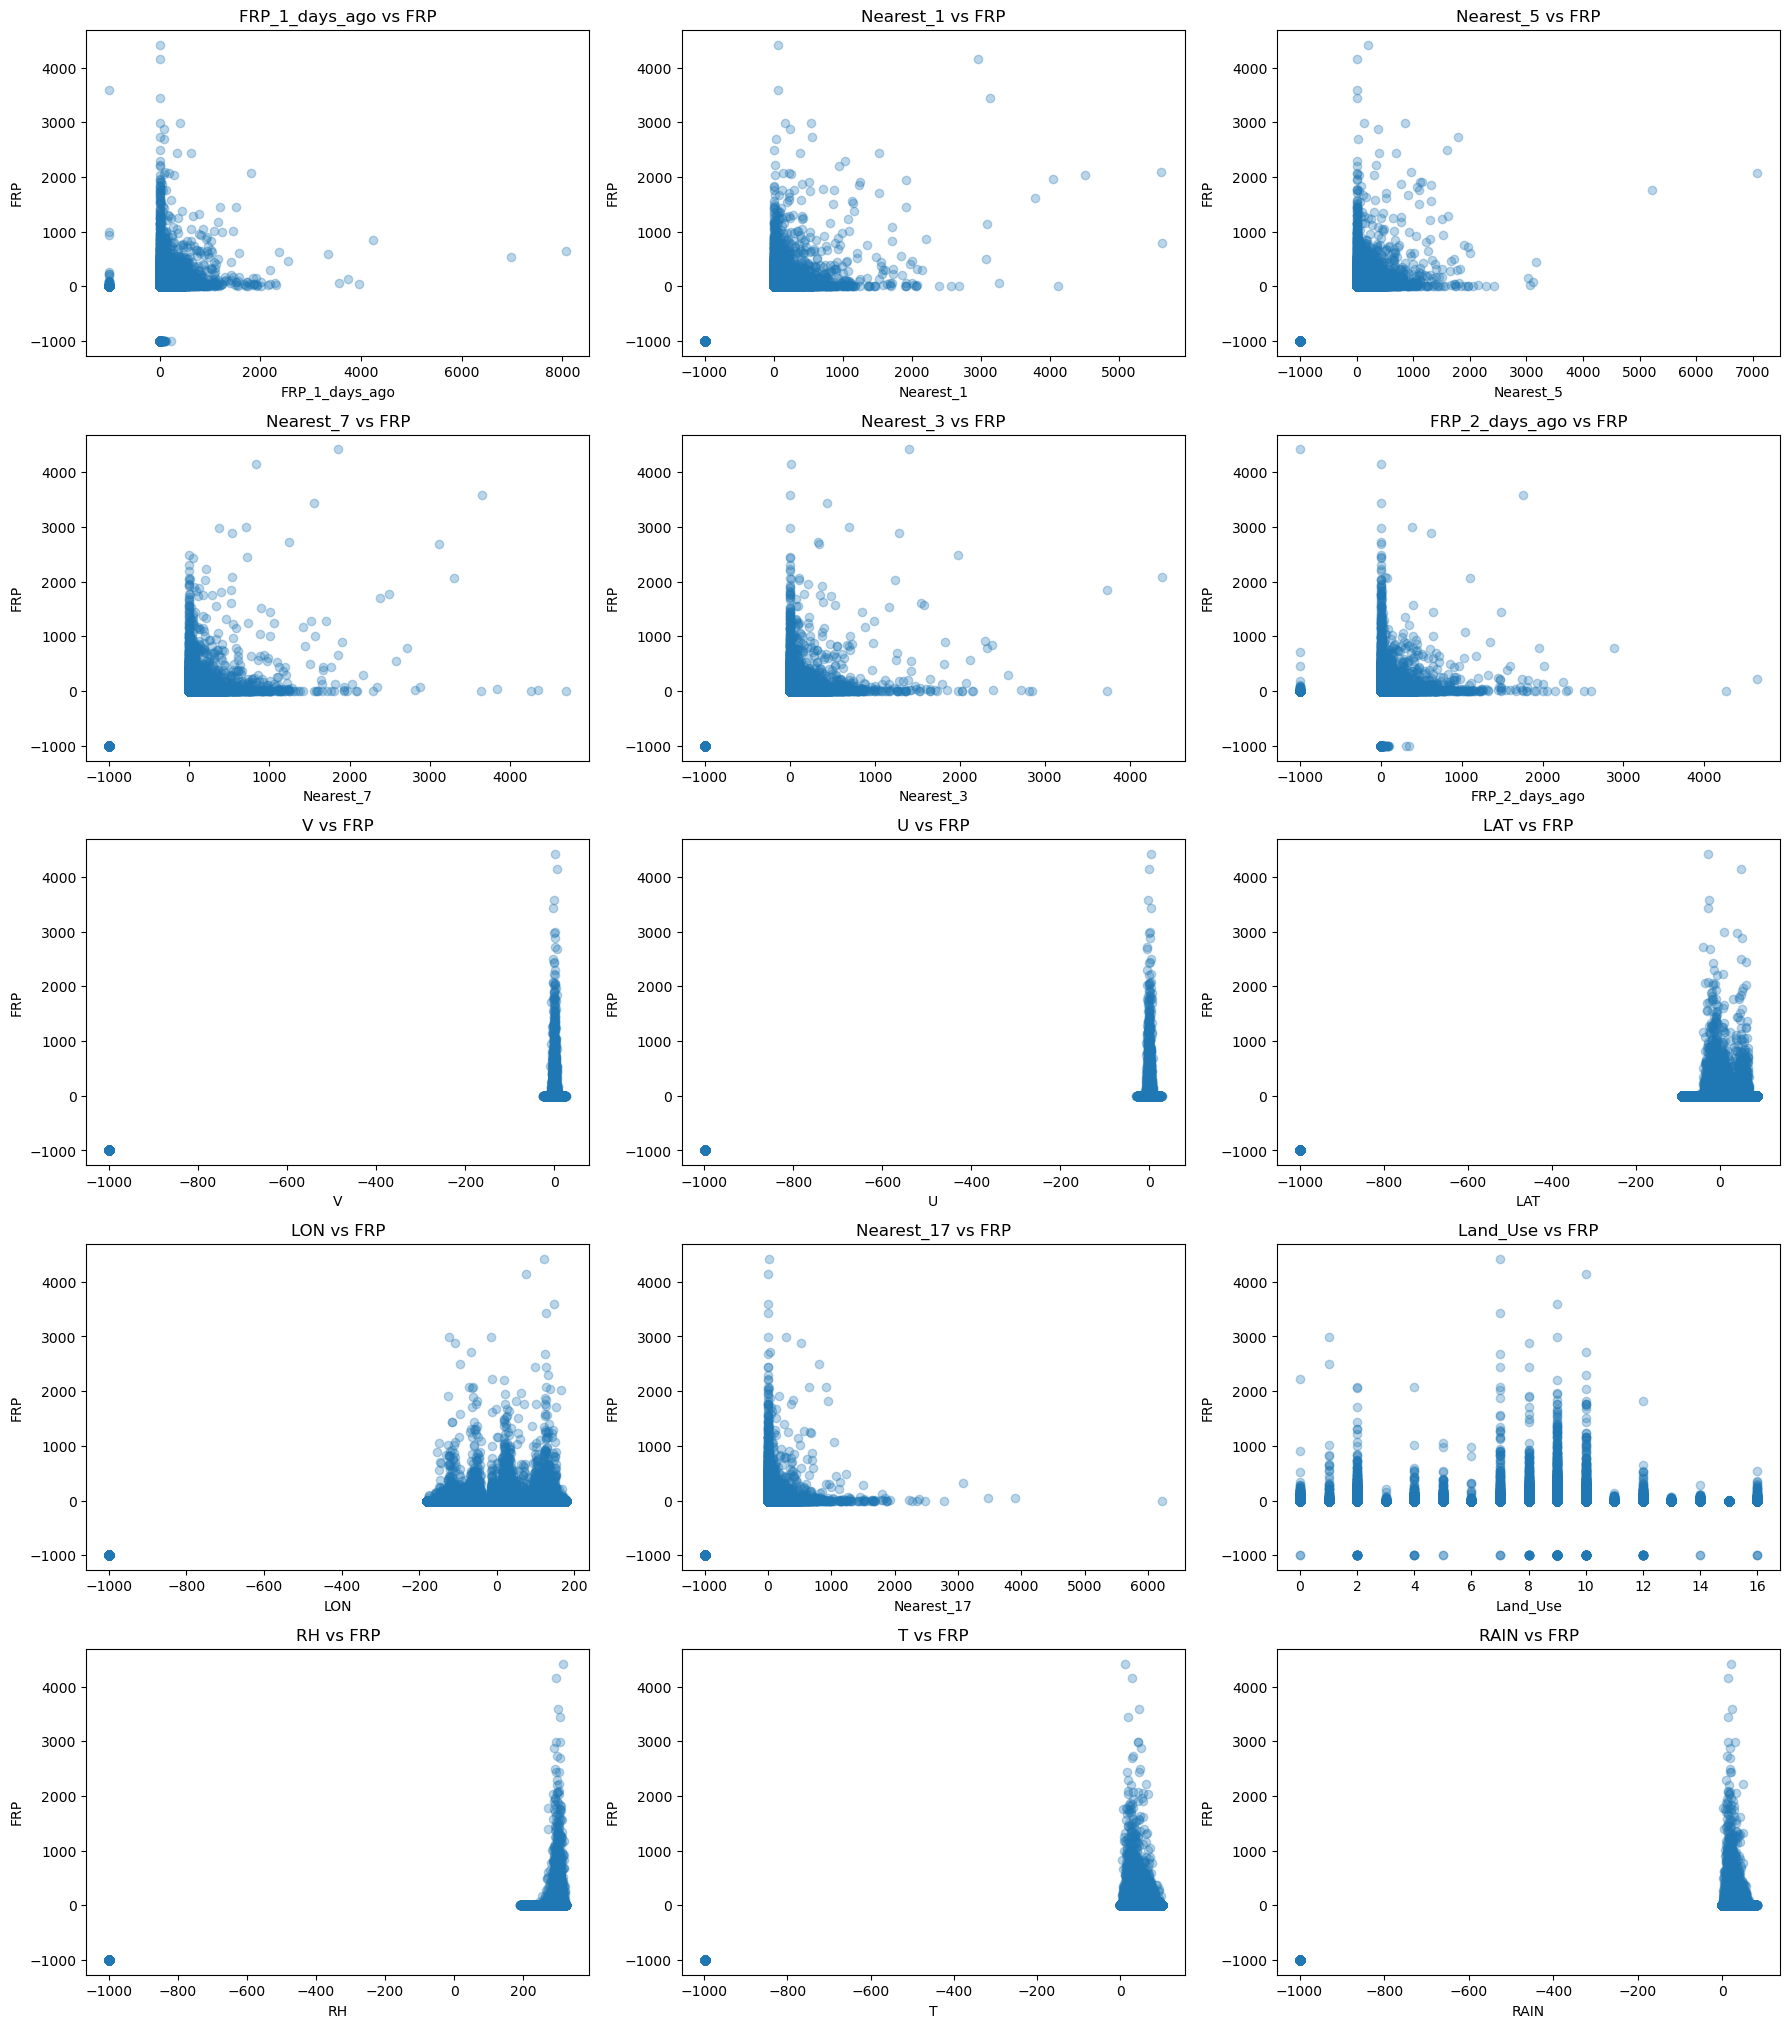

In [5]:
import matplotlib.pyplot as plt

# Define the number of rows and columns
n_cols = 3
n_rows = (len(df.columns) - 1) // n_cols + 1  # Adjust for the number of features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):  # Exclude the 'FRP' column
    axes[i].scatter(df[column], df['FRP'], alpha=0.3)
    axes[i].set_title(f'{column} vs FRP')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('FRP')

# Remove empty subplots if any
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Box plots for comparison

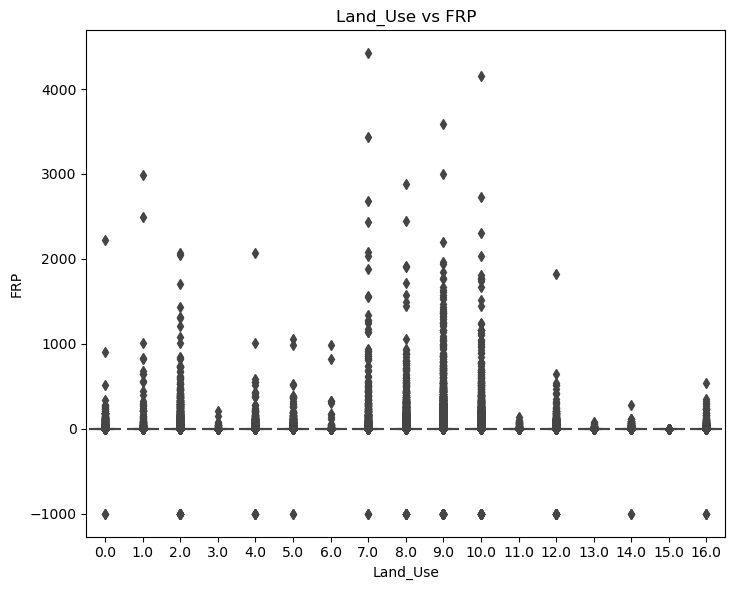

In [6]:
categorical_columns = ['Land_Use']  # Example of a categorical column
n_cols = 2
n_rows = len(categorical_columns) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.boxplot(x=column, y='FRP', data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs FRP')

# Remove empty subplots if any
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
